# SurvSHAP(t): Time-Dependent Explanations Of Machine Learning Survival Models
### M. Krzyziński, M. Spytek, H. Baniecki, P. Biecek
## Experiment 3: Real-world use case: predicting survival of patients with heart failure
(https://github.com/MI2DataLab/survshap/blob/main/exp3.ipynb)

#### Imports

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from abc import ABC
import torchtuples as tt
from plotly.figure_factory import np
from pycox.models import DeepHitSingle
from sksurv.functions import StepFunction
from survshap import SurvivalModelExplainer, PredictSurvSHAP
import timeit

#### Preparing data and models 

In [15]:
real_data = pd.read_csv("data/exp3_heart_failure_dataset.csv")
real_data.rename(columns={"DEATH_EVENT": "event"}, inplace=True)

In [16]:
df_train = real_data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
train_column_names = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine",
                      "serum_sodium", "sex", "smoking"]
max_time = real_data.time.max()

In [17]:
cols_standardize = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
cols_leave = ['sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [18]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [19]:
y_train = (df_train['time'].values, df_train['event'].values)
y_val = (df_val['time'].values, df_val['event'].values)

train = (x_train, y_train)
val = (x_val, y_val)

In [20]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = max_time + 1
batch_norm = True
dropout = 0.1

network = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

class CustomDeepHitSingle(DeepHitSingle, ABC):
    def __init__(self, net, optimizer=None, device=None, duration_index=None, alpha=0.2, sigma=0.1, loss=None):
        super().__init__(net, optimizer=optimizer, device=device, duration_index=duration_index, alpha=alpha,
                         sigma=sigma, loss=loss)


    def predict_survival_function(self, X, return_array=False):
        preds = self.predict_surv_df(X.values)
        ret = [StepFunction(x=np.arange(0, preds.shape[0]), y=preds[column].values) for i, column in enumerate(preds)]
        return ret

model = CustomDeepHitSingle(network, optimizer=tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=np.arange(0, max_time + 1))

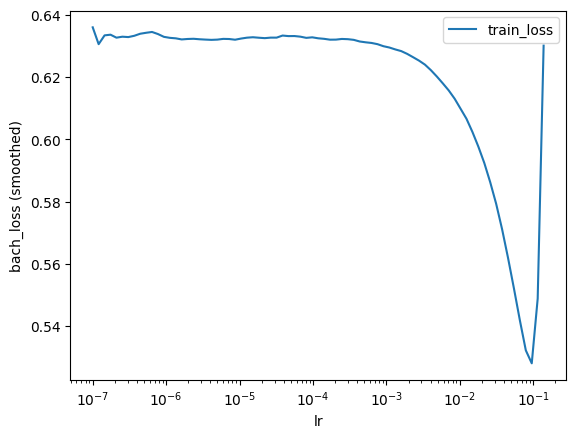

In [21]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [22]:
model.optimizer.set_lr(lr_finder.get_best_lr() * 0.7)

In [23]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6304,	val_loss: 0.7851
1:	[0s / 0s],		train_loss: 0.6072,	val_loss: 0.7791
2:	[0s / 0s],		train_loss: 0.5864,	val_loss: 0.7746
3:	[0s / 0s],		train_loss: 0.5662,	val_loss: 0.7705
4:	[0s / 0s],		train_loss: 0.5460,	val_loss: 0.7675
5:	[0s / 0s],		train_loss: 0.5268,	val_loss: 0.7644
6:	[0s / 0s],		train_loss: 0.5161,	val_loss: 0.7614
7:	[0s / 0s],		train_loss: 0.4994,	val_loss: 0.7589
8:	[0s / 0s],		train_loss: 0.4815,	val_loss: 0.7572
9:	[0s / 0s],		train_loss: 0.4742,	val_loss: 0.7555
10:	[0s / 0s],		train_loss: 0.4617,	val_loss: 0.7544
11:	[0s / 0s],		train_loss: 0.4510,	val_loss: 0.7537
12:	[0s / 0s],		train_loss: 0.4291,	val_loss: 0.7532
13:	[0s / 0s],		train_loss: 0.4047,	val_loss: 0.7531
14:	[0s / 0s],		train_loss: 0.3987,	val_loss: 0.7539
15:	[0s / 0s],		train_loss: 0.4064,	val_loss: 0.7552
16:	[0s / 0s],		train_loss: 0.3749,	val_loss: 0.7569
17:	[0s / 0s],		train_loss: 0.3446,	val_loss: 0.7592
18:	[0s / 0s],		train_loss: 0.3406,	val_loss: 0.7620
19:

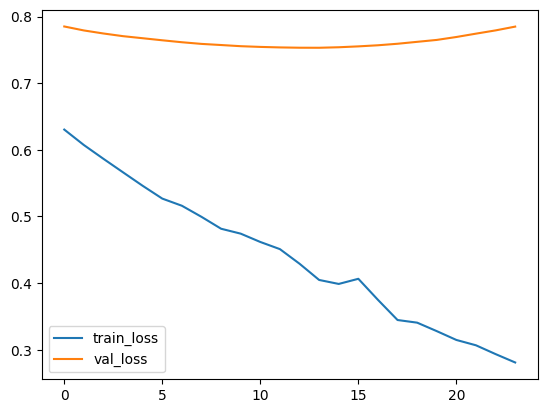

In [24]:
_ = log.plot()

In [25]:
y_dtype = np.dtype({'names':['event', 'time'], 'formats':[np.uint8, np.uint8]})
y = np.array([tuple(row) for row in np.stack((y_train[1], y_train[0])).transpose(1, 0)], dtype=y_dtype)
model_exp = SurvivalModelExplainer(model, pd.DataFrame(x_train, columns=train_column_names), y)
n_obs = len(x_test)
survshaps = [None for i in range(n_obs)]
time_array = []
for i, obs in enumerate(x_test[:1]):
    xx = pd.DataFrame(np.atleast_2d(obs), columns=train_column_names)
    survshap = PredictSurvSHAP()
    start = timeit.timeit()
    survshap.fit(model_exp, xx)
    end = timeit.timeit()
    print(end - start)
    time_array.append(end - start)
    survshaps[i] = survshap
    survshap.plot()
    plt.show()
    print(survshap.result.head())

-0.00134177399922919


                         variable_str             variable_name  \
0                         age = 0.831                       age   
1  creatinine_phosphokinase = -0.4892  creatinine_phosphokinase   
2           ejection_fraction = 1.771         ejection_fraction   
3                 platelets = -0.1016                 platelets   
4          serum_creatinine = -0.2915          serum_creatinine   

   variable_value  B  aggregated_change     t = 0     t = 1     t = 2  \
0        0.830985  0           5.228015 -0.000975 -0.001807 -0.002434   
1       -0.489152  0           1.181423 -0.000247 -0.000517 -0.000969   
2        1.770741  0           5.531200  0.000693 -0.000120 -0.001084   
3       -0.101610  0           0.492245  0.000094 -0.000204 -0.000202   
4       -0.291505  0           1.498599 -0.000010  0.000114 -0.000018   

      t = 3     t = 4  ...   t = 276   t = 277   t = 278   t = 279   t = 280  \
0 -0.003586 -0.004798  ... -0.007730 -0.006172 -0.005810 -0.006106 -0.005964  